In [118]:
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from shapely import box
import pandas as pd
from geograypher.utils.geospatial import ensure_non_overlapping_polygons
from geograypher.utils.geospatial import ensure_projected_CRS

In [119]:
METADATA_FILE = Path("/ofo-share/drone-imagery-organization/3c_metadata-extracted/all-mission-polygons-w-metadata.gpkg")
PREDS_FOLDER = Path("/ofo-share/repos-david/UCNRS-experiments/data/final/post_processed_shifted_predictions")

ENSURE_NONOVERLAPPING = False
#Quail, BORR, Hastings
RESERVE = "Hastings"
ONLY_LEAF_ON = True

# Start and end date as month and year (mmdd)
LEAF_ON_START_DATE = 415
LEAF_ON_END_DATE = 1200

<Axes: >

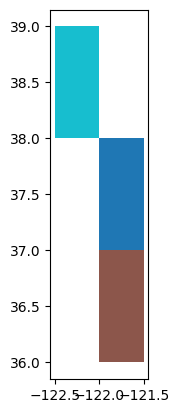

In [120]:
# The generous bounds of the reserves
reserve_bounds = gpd.GeoDataFrame(
    {
        "geometry":
            [
                box(xmin=-122.5, ymin=38, xmax=-122, ymax=39),
                box(xmin=-122, ymin=37, xmax=-121.5, ymax=38),
                box(xmin=-122, ymin=36, xmax=-121.5, ymax=37)
            ],
        "reserve": ["Quail", "BORR", "Hastings"]
    },
    crs=4326
)
reserve_bounds.plot("reserve")

In [121]:
def plot_map(gdf, title=None):
    ax = gdf.plot("class_ID", cmap="tab10", vmin=-0.5, vmax=9.5, legend=True, categorical=False)
    if title is not None:
        ax.set_title(title)

In [133]:
def compute_standardized(preds, shared_region, reserve, year, ensure_nonoverlapping=False):
    if len(preds) == 0:
        return None

    dissolved = preds.dissolve(by="class_names", as_index=False)
    plot_map(preds, title=f"{year}: before clipping")

    subset = dissolved.clip(shared_region)
    if ensure_nonoverlapping:
        subset = ensure_non_overlapping_polygons(subset)

    plot_map(subset, title=f"{year}: after clipping")
    plt.savefig(Path(f"../data/vis/final_cover_{reserve}_2020.png"))

    subset = ensure_projected_CRS(subset)
    # Compute the area fraction
    total_area = gpd.GeoDataFrame(data={"geometry": shared_region}, crs=4326).to_crs(subset.crs).area.values[0]

    subset["area_fraction"] = subset.area / total_area

    return subset

In [123]:
metadata = gpd.read_file(METADATA_FILE)
metadata = metadata[["mission_id", "earliest_datetime_local_derived"]]

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [124]:
pred_files = sorted(PREDS_FOLDER.glob("*"))

# Load predictions

<Axes: >

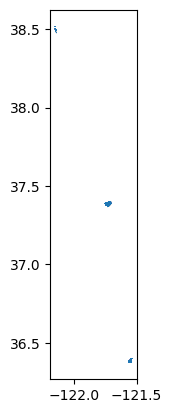

In [125]:
preds = []

for pred_file in pred_files:
    pred = gpd.read_file(pred_file)
    pred["mission_id"] = pred_file.stem
    # Something is weird with this dataset and it's a collection of individual polygons
    if pred_file.stem == "000559":
        pred = pred.dissolve("class_names", as_index=False)

    preds.append(pred)

all_preds = pd.concat(preds)
all_preds.plot()

# Add additional information

In [126]:
# Combine the metadata with the predictions
all_preds = all_preds.merge(metadata, on="mission_id")

# Restrict to the time period that leaves would be one
if ONLY_LEAF_ON:
    # Extract the mmdd representation of the month and day
    int_month_day = all_preds["earliest_datetime_local_derived"].dt.strftime('%m%d').astype(int)

    index = (int_month_day > LEAF_ON_START_DATE) & (int_month_day < LEAF_ON_END_DATE)

    print(f"{len(index) - index.sum()} rows dropped")
    all_preds = all_preds[index]

# Add the information about which reserve it corresponds to
all_preds = gpd.sjoin(all_preds, reserve_bounds, how="left", predicate="intersects")

143 rows dropped


Subset to a single reserve

In [127]:

# Select data only from one reserve if requested
if RESERVE is not None:
    reserve_preds = all_preds[all_preds["reserve"] == RESERVE]
else:
    reserve_preds = all_preds

Split by year

In [128]:
year = reserve_preds["earliest_datetime_local_derived"].dt.year

preds_2020 = reserve_preds[year == 2020]
preds_2023 = reserve_preds[year == 2023]
preds_2024 = reserve_preds[year == 2024]

Compute the shared region across non-empty reserves

<Axes: >

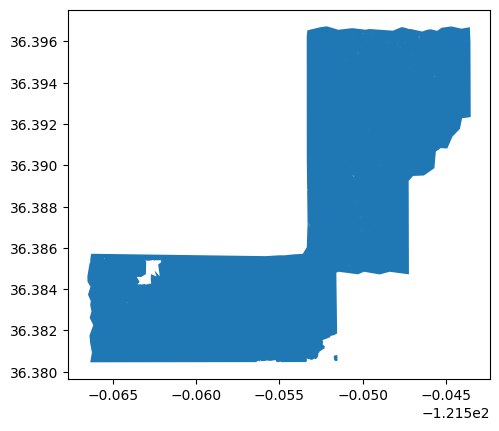

In [129]:
boundary_2020 = preds_2020.dissolve()
boundary_2023 = preds_2023.dissolve()
boundary_2024 = preds_2024.dissolve()

# We do some extra work to make this robust to years that have no data and exclude them from the calculation of the intersection
shared_region = pd.concat((boundary_2020, boundary_2023, boundary_2024)).dissolve()

if len(boundary_2020) > 0:
    shared_region = shared_region.intersection(boundary_2020)
if len(boundary_2023) > 0:
    shared_region = shared_region.intersection(boundary_2023)
if len(boundary_2024) > 0:
    shared_region = shared_region.intersection(boundary_2024)

shared_region.plot()

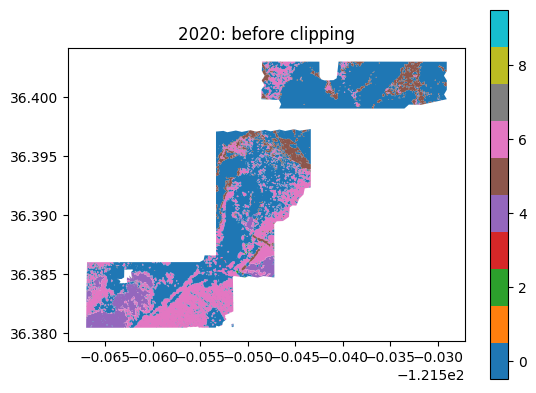

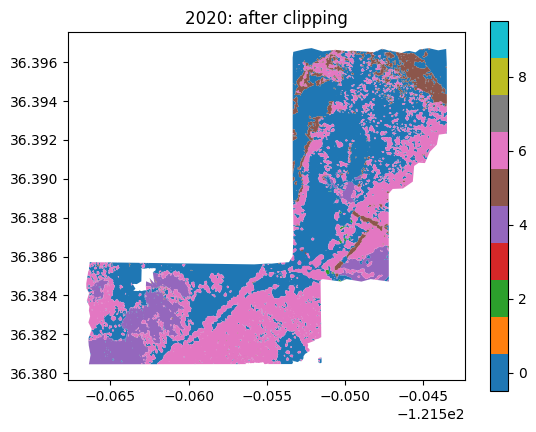

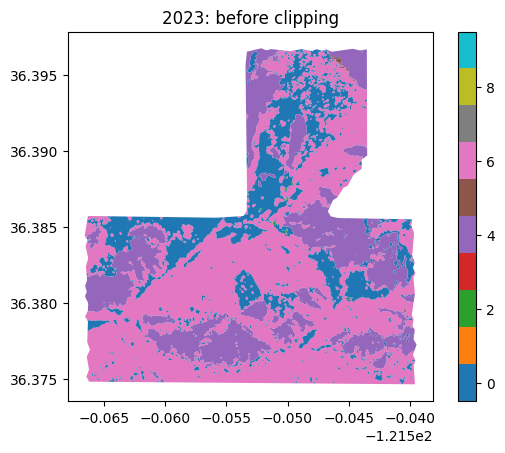

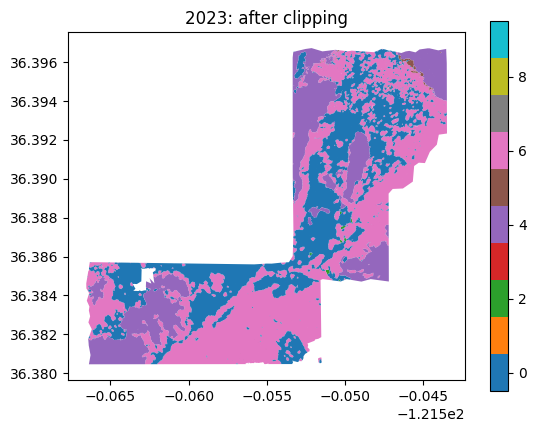

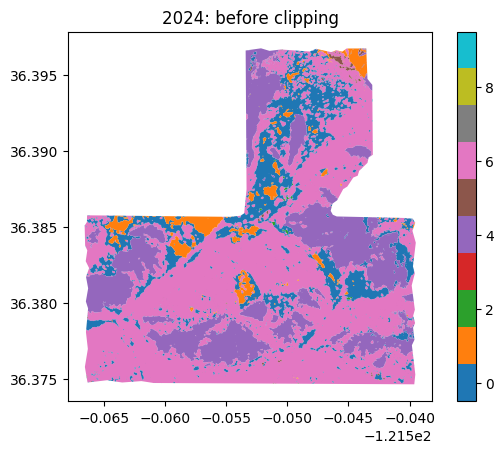

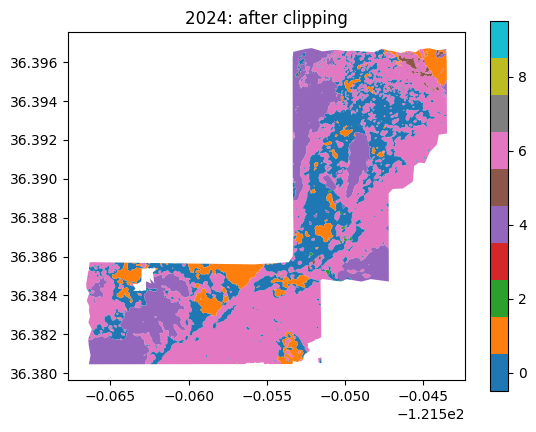

In [134]:
standardized_2020 = compute_standardized(preds_2020, shared_region, reserve=RESERVE, year="2020")
standardized_2023 = compute_standardized(preds_2023, shared_region, reserve=RESERVE, year="2023")
standardized_2024 = compute_standardized(preds_2024, shared_region, reserve=RESERVE, year="2024")

Make a table to summarize the class fractions per

In [ ]:
final_table = np.zeros((8,3))

if standardized_2020 is not None:
    final_table[standardized_2020["class_ID"].to_numpy().astype(int), 0] = standardized_2020["area_fraction"]
if standardized_2023 is not None:
    final_table[standardized_2023["class_ID"].to_numpy().astype(int), 1] = standardized_2023["area_fraction"]
if standardized_2024 is not None:
    final_table[standardized_2024["class_ID"].to_numpy().astype(int), 2] = standardized_2024["area_fraction"]

final_table_vis = pd.DataFrame(
    data=final_table,
    columns=["2020", "2023", "2024"],
    index=["Bare Earth", "Herbaceous Live", "Man Made", "Shrub Dead", "Shrub Live", "Tree Dead", "Tree Live", "Water"])
final_table_vis

,2020,2023,2024
Bare Earth,0.470118,0.312834,0.251827
Herbaceous Live,0.000001,0.000000,0.076582
Man Made,0.001530,0.001082,0.001519
Shrub Dead,0.000092,0.000001,0.000000
Shrub Live,0.101142,0.222249,0.194716
Tree Dead,0.056679,0.002232,0.005857
Tree Live,0.371803,0.461602,0.469498
Water,0.000000,0.000000,0.000000
